In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from lbg_forecast import emulator as em
from lbg_forecast import population_model as pop

In [2]:
bands = ["u","g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

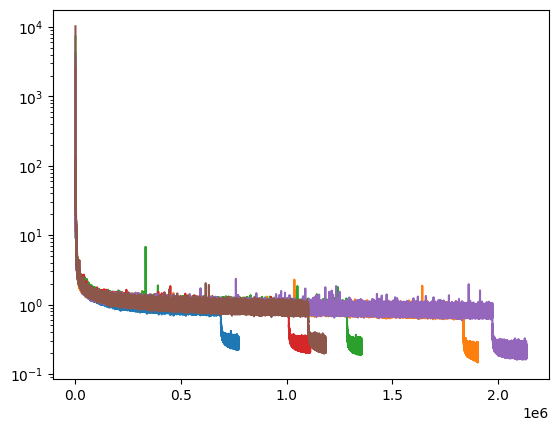

In [3]:
for x in loss_bands:
    plt.plot(x)

plt.yscale("log")

0.27456730604171753
0.1586080640554428
0.2254231721162796
0.2700735926628113
0.22408194839954376
0.2617095112800598


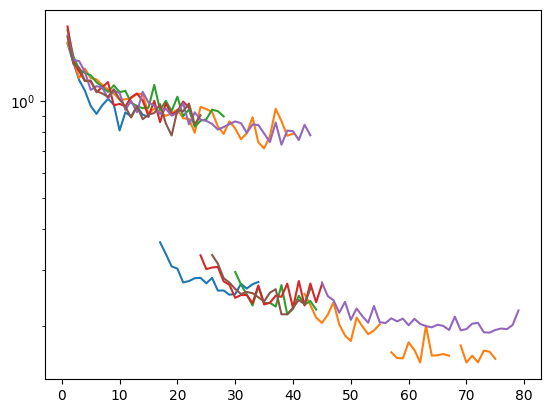

In [4]:
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [6]:
sps_params_train = np.load("training_data/sps_parameters_51000000.npy")
phot_train = np.load("training_data/photometry_51000000.npy")
phot_train[:10, :]

array([[44.01180649, 46.07352092, 46.24761003, 39.69697075, 36.70353593,
        34.79124754],
       [39.65268998, 37.77053124, 36.87723783, 36.38322282, 36.07364946,
        35.81186297],
       [30.8154874 , 32.88504428, 34.42711491, 27.52096284, 24.79378373,
        21.27997519],
       [70.84634175, 72.89848796, 74.94639949, 70.91288306, 63.94092771,
        61.43376454],
       [48.52748667, 50.71676985, 51.55131717, 46.66224805, 43.64349346,
        38.81211316],
       [71.94751033, 74.37519329, 77.02961267, 74.23491999, 72.10731795,
        61.85806938],
       [55.4760906 , 57.62187129, 59.15056233, 55.06203183, 51.99479973,
        45.77702118],
       [46.12390834, 46.50412309, 43.23275045, 41.44216961, 38.8959299 ,
        36.91158272],
       [62.19058994, 64.37991107, 66.39028015, 64.0652919 , 58.30986898,
        52.44098859],
       [38.1056629 , 35.54707791, 34.39520038, 33.95087692, 33.07741408,
        32.47147148]])

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


Text(0, 0.5, '$\\Delta m$')

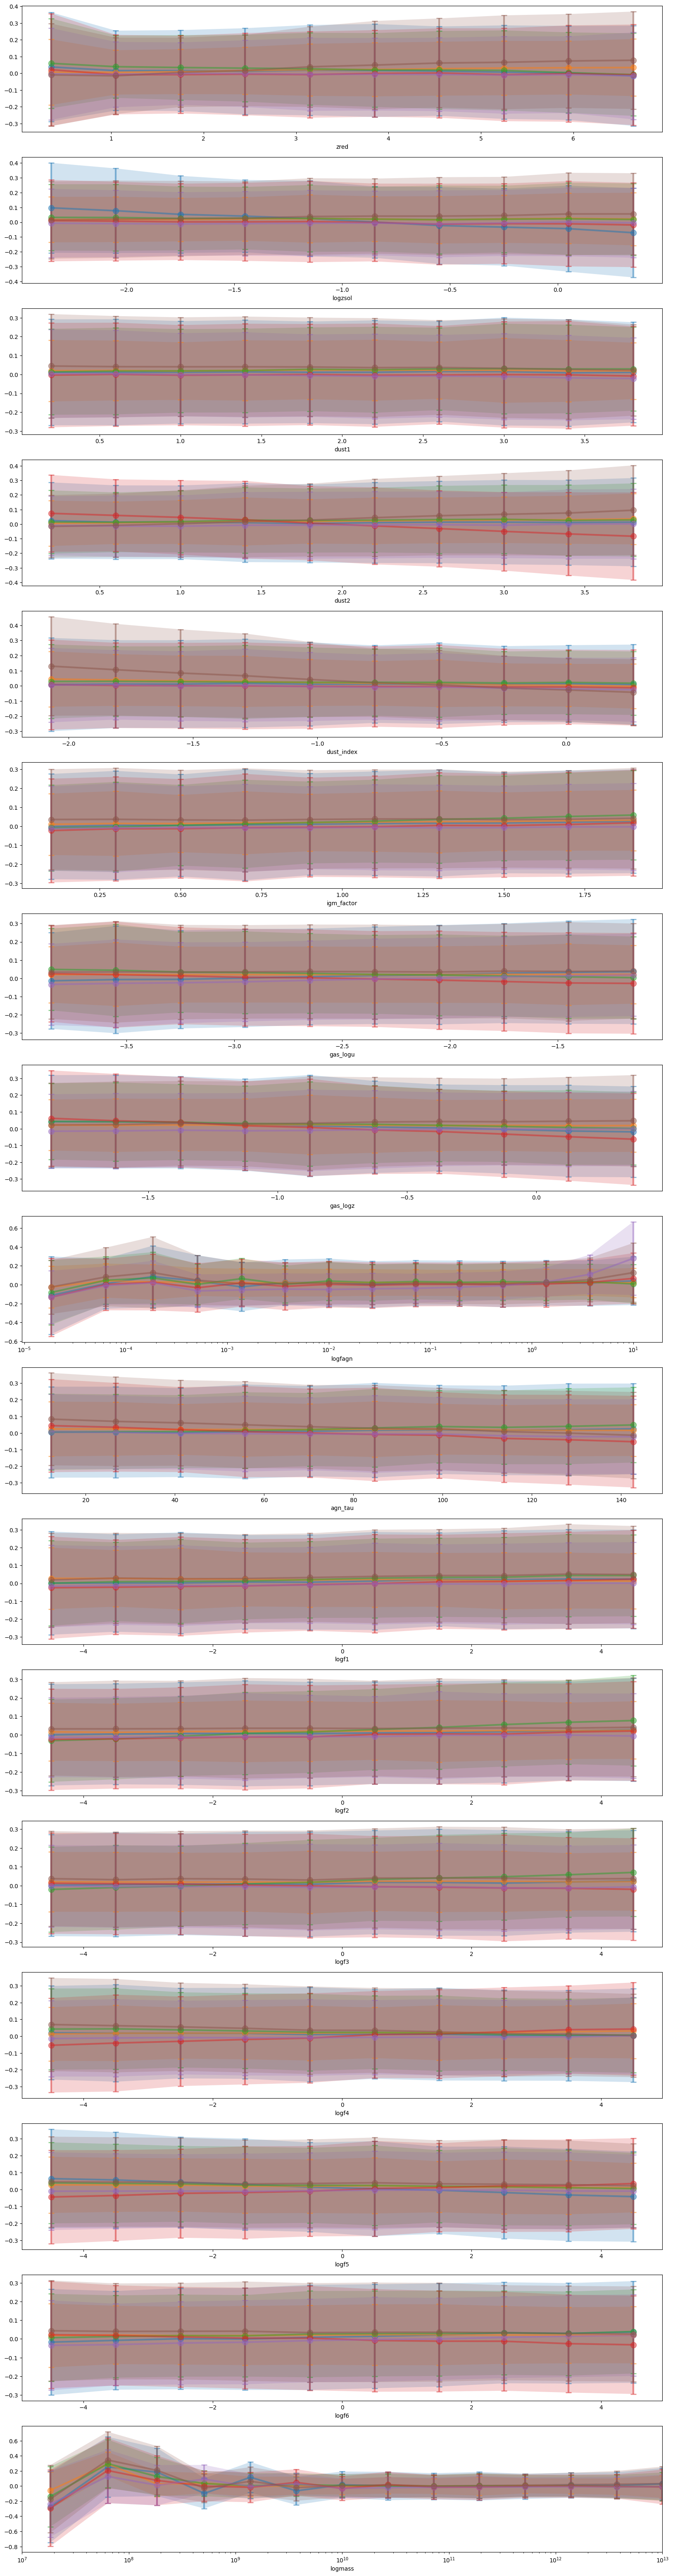

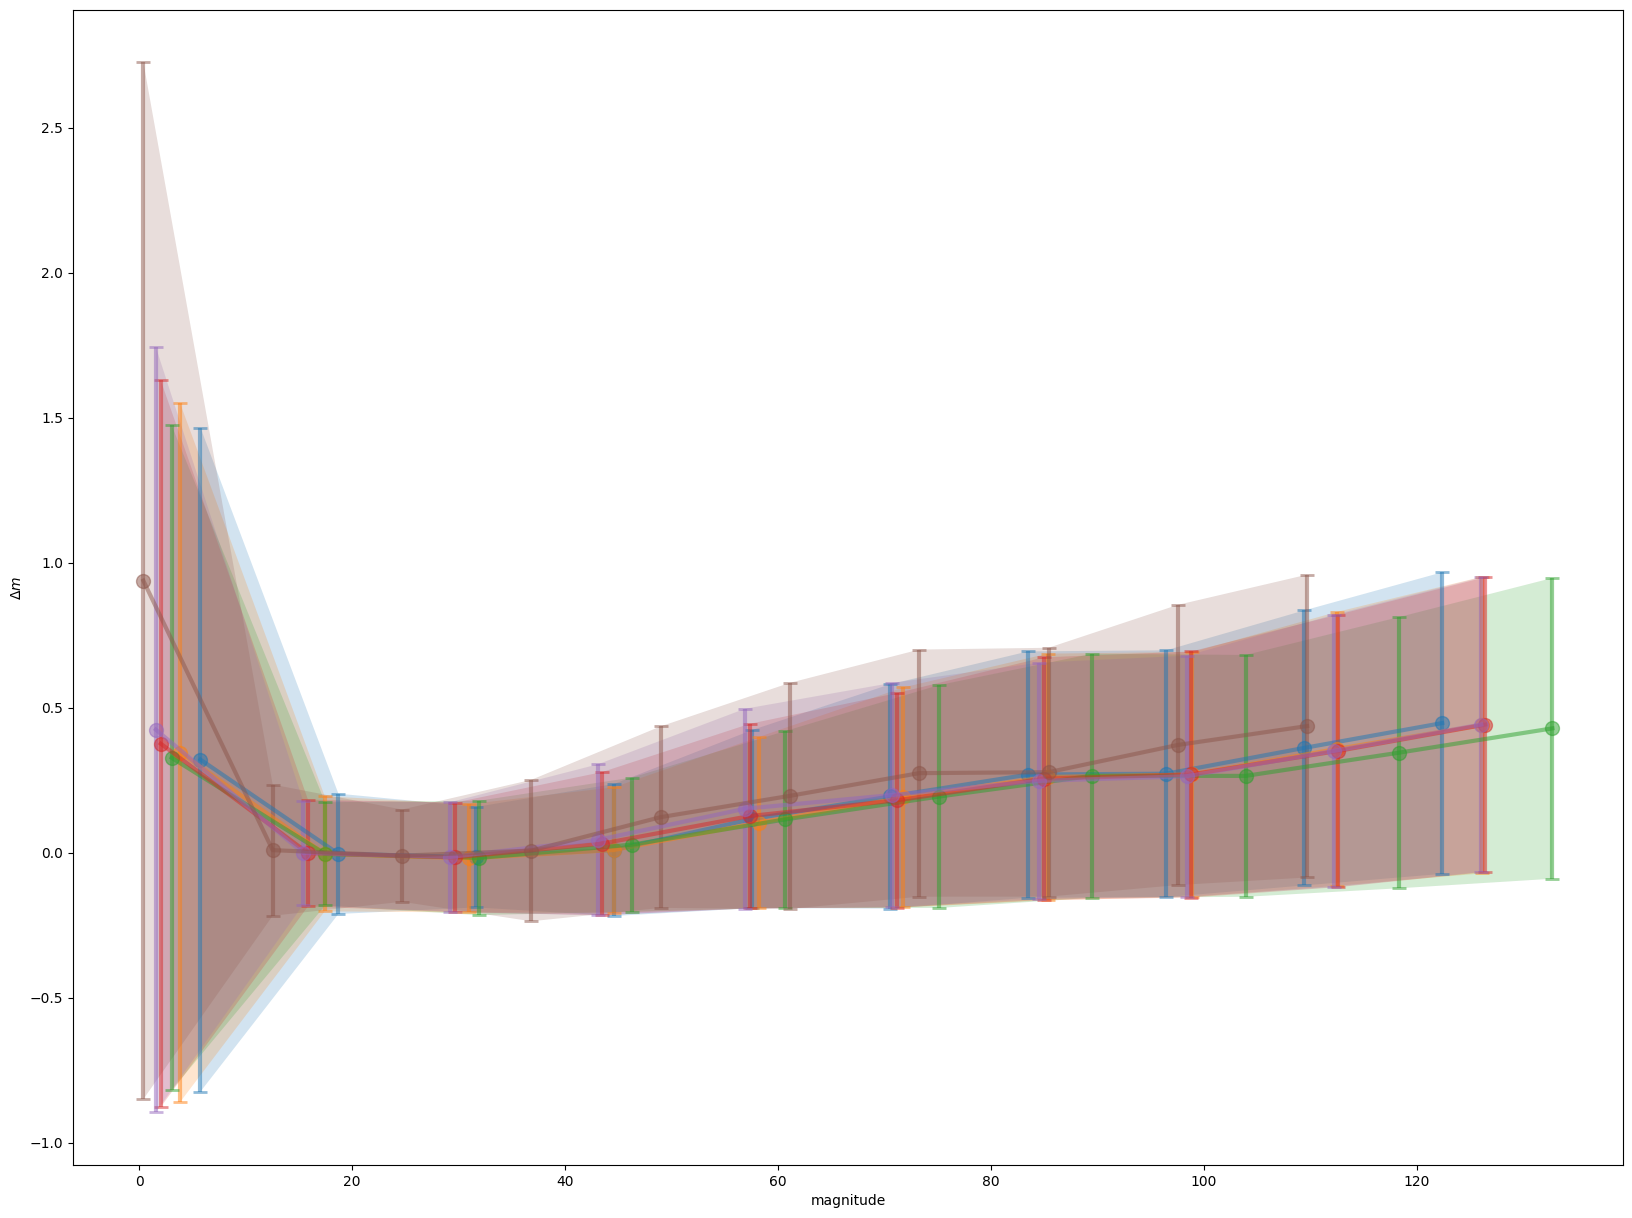

In [7]:
nsamples=160000
sps_params = sps_params_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params[:,]) #SLOW, TODO: BATCH!!!!!
m_true = phot_train[:nsamples, :]
nbands = 6 

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    for j in range(nbands):
        dm = m_mimic[:, j]-m_true[:, j]
        #axes[i].scatter(sps_params[:, i], dm[:,], alpha=alpha)
        

        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            axes[i].set_xscale('log')

        axes[i].set_xlabel(pop.sps_parameter_names()[i])
        if(pop.sps_parameter_names()[i] == "logmass" or pop.sps_parameter_names()[i] == "logfagn"):
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std', bins=np.logspace(np.log10(np.min(sps_params[:, i])), np.log10(np.max(sps_params[:, i])), 15))
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2
        else:
            bin_means, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'mean')
            bin_std, bin_edges, binnumber = sc.stats.binned_statistic(sps_params[:, i], dm[:,],'std')
            bin_width = (bin_edges[1] - bin_edges[0])
            bin_centers = bin_edges[1:] - bin_width/2

        axes[i].errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
        axes[i].fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

        if(pop.sps_parameter_names()[i] == "logmass"):
            axes[i].set_xlim(1e7, 1e13)



fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

for j in range(nbands):
    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'mean')
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(m_true[:, j], dm[:,],'std')
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2


    axes2.errorbar(bin_centers, bin_means, bin_std, alpha=0.5, ms=20, marker=".", elinewidth=3, capsize=5, capthick=2, lw=3)
    axes2.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2)

axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')



In [8]:
len(np.where(phot_train[:, 5] > 40)[0])/len(phot_train[:, 0])

0.27566798039215684

In [9]:
np.std(dm)

0.261427006701817